## Run this notebook

You can launch this notebook in VEDA JupyterHub by clicking the link below.

[Launch in VEDA JupyterHub (requires access)](https://hub.openveda.cloud/hub/user-redirect/git-pull?repo=https://github.com/NASA-IMPACT/veda-docs&urlpath=lab/tree/veda-docs/notebooks/tutorials/zonal-statistics-titiler-validation.ipynb&branch=main) 

<details><summary>Learn more</summary>
    
### Inside the Hub

This notebook was written on the VEDA JupyterHub and as such is designed to be run on a jupyterhub which is associated with an AWS IAM role which has been granted permissions to the VEDA data store via its bucket policy. The instance used provided 16GB of RAM. 

See (VEDA Analytics JupyterHub Access)[https://nasa-impact.github.io/veda-docs/veda-jh-access.html] for information about how to gain access.

### Outside the Hub

The data is in a protected bucket. Please request access by emailng aimee@developmentseed.org or alexandra@developmentseed.org and providing your affiliation, interest in or expected use of the dataset and an AWS IAM role or user Amazon Resource Name (ARN). The team will help you configure the cognito client.

You should then run:

```
%run -i 'cognito_login.py'
```
    
</details>

## Approach

### Motivation

The VEDA backend (via TiTiler) provides an API endpoint for computing zonal statistics (average, standard deviation, and other metrics over a geographic subset) across gridded (raster) data such as satellite imagery or climate datasets.

Some statistics, such as average, median, standard deviation, or percentiles are sensitive to differences in grid cell / pixel sizes: when some grid cells are (in metric units) have a larger area than others, the values in these cells will be under-represented. Grid cell sizes depends on the grid / projection of the data.

Varying grid cell sizes is common for climate datasets that are stored on a grid in geographic coordinates (lat/lon), for example a 0.1 degree by 0.1 degree global grid. Here, grid cell size will decrease from low to high latitudes. Computing averages over large spans of latitude will result in statistics where values closer to the poles are strongly over-represented. 

To avoid this inaccuracy in zonal statistics computed with our API, we introduced a method to reproject the source data to an equal-area projection as an intermediate step in calculating statistics.

Note: this reprojection is not needed for example for accurate zonal statistics on a Sentinel-2 scene, using the Military Grid Reference System (MGRS) and a Mercator (UTM) projection. Here, pixel areas are the same across the scene in the native projection.

### In this notebook

This notebook presents a validation of VEDA's API for zonal statistics against a known way to compute area-weighted averages for gridded datasets on a regular lat/lon grid.

For illustration, we choose a real dataset from the VEDA data catalog and a subsetting area that spans a large latitude range.

The figures below show the average calculated over that area of interest with the different methods, for comparison.

In [1]:
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import requests
import rasterio
import rasterio.crs
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pystac_client import Client

## Load and inspect dataset from GHGC STAC catalog

In [3]:
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

COLLECTION_ID = "casagfed-carbonflux-monthgrid-v3"
ASSET_NAME = "npp"

In [4]:
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(COLLECTION_ID)

In [5]:
items = list(collection.get_all_items())[:15]

In [6]:
with rasterio.open(items[0].assets[ASSET_NAME].href) as ds:
    print(ds.profile)
    
    assert ds.crs == rasterio.crs.CRS.from_epsg(4326)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 720, 'height': 360, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


## Define formula for grid cell area for geographic coordinates

In [7]:
def _get_unique_diff(arr):
    assert np.ndim(arr) == 1
    deltas = np.diff(arr)
    
    if not np.allclose(deltas, deltas[0]):    
        raise ValueError(f"The spacing in the array is not uniform: {list(np.unique(deltas))}")
    return deltas[0]


def grid_cell_area(lat):
    """
    https://www.mathworks.com/matlabcentral/answers/447847-how-to-calculate-the-area-of-each-grid-cell
    https://gis.stackexchange.com/a/28156
    """
    # get lat spacing asserting it is uniform
    dlat = _get_unique_diff(lat)
    
    # calculate cell edge lat
    lat_edge = lat - dlat / 2.
    
    # radius of Earth in meters
    R_e = 6371e3
    
    # calculate cell area as a function of latitude
    return R_e ** 2 * (np.sin(np.radians(lat_edge + dlat)) - np.sin(np.radians(lat_edge))) * np.radians(dlat)

## Define a geometry to average over

In [8]:
AOI_NAME = "Americas south to north"

AOI = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -115,
              82
            ],
            [
              -115,
              -82
            ],
            [
              -43,
              -82
            ],
            [
              -43,
              82
            ],
            [
              -115,
              82
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

## Compute averages with Xarray

In [9]:
timeseries = {
    "start_datetime": [],
    "average_weighted": [],
    "average_unweighted": []
}

for item in tqdm.tqdm(items):
    item_uri = item.assets[ASSET_NAME].href

    with xr.open_dataset(item_uri, engine="rasterio") as xds:
        
        # calculate area as a function of latitude
        area_lat = grid_cell_area(xds.y.values)
        area_lat_2d = np.ones((len(xds.y), len(xds.x))) * area_lat[:, np.newaxis]
        xds["area"] = xr.DataArray(area_lat_2d, dims=("y", "x"))
        
        # clip to geometry
        xds_clip = xds.rio.clip([AOI["features"][0]["geometry"]])
        
        # get data arrays
        data = xds_clip["band_data"].isel(band=0).to_masked_array()
        weights = xds_clip["area"].to_masked_array()
        weights.mask = data.mask
        
        # calculate averages
        average_weighted = (data * weights).sum() / weights.sum()
        average_unweighted = data.mean()
        
        timeseries["average_weighted"].append(average_weighted)
        timeseries["average_unweighted"].append(average_unweighted)
        timeseries["start_datetime"].append(item.properties["start_datetime"])
        
        lat_vals = xds.y.values

100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


In [10]:
df = pd.DataFrame(timeseries).set_index("start_datetime")
df.index = pd.to_datetime(df.index)

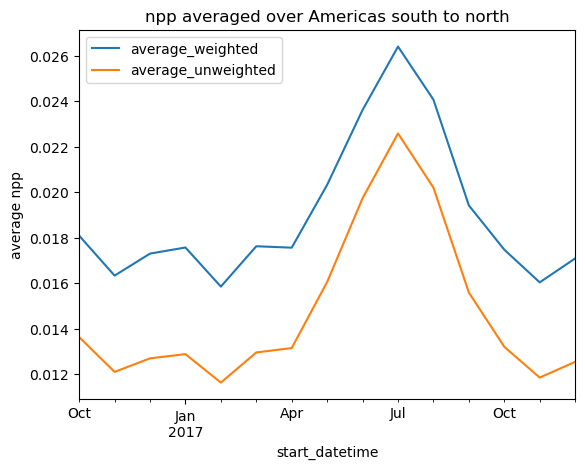

In [11]:
df.plot(ylabel=f"average {ASSET_NAME}", title=f"{ASSET_NAME} averaged over {AOI_NAME}") ;

## Plot grid cell area as a function of latitude

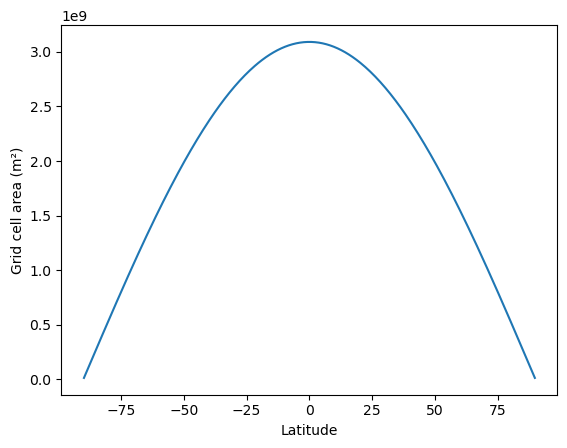

In [12]:
plt.plot(lat_vals, area_lat_2d[:, 0])
plt.ylabel("Grid cell area (m²)")
plt.xlabel("Latitude") ;

## Compute zonal averages using TiTiler API

We make use of the option on TiTiler to reproject the data subset to an equal-area projection ([Equal Area Cylindrical](https://proj.org/en/9.3/operations/projections/cea.html)) before computing the statistics.

In [13]:
WORKING_PROJECTION = "+proj=cea"

In [14]:
def generate_stats(item, geojson, asset_name, params=None):
    params = params or {}
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={
            "url": item.assets[asset_name].href,
            **params
        },
        json=geojson,
    )
    result.raise_for_status()
    result_data = result.json()
    return {
        **result_data["features"][0]["properties"]["statistics"]["b1"],
        "start_datetime": item.properties["start_datetime"],
    }

In [15]:
timeseries_titiler_noproj = []
timeseries_titiler_proj = []

for item in tqdm.tqdm(items):
    # generate stats with and without reprojection
    stats_noproj = generate_stats(item, AOI, ASSET_NAME)
    stats_proj = generate_stats(item, AOI, ASSET_NAME, params={"dst_crs": WORKING_PROJECTION})

    timeseries_titiler_noproj.append(stats_noproj)
    timeseries_titiler_proj.append(stats_proj)

100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


In [16]:
def _to_dataframe(stats):
    df = pd.DataFrame(stats)
    df = df[["start_datetime", "mean"]]
    df = df.set_index("start_datetime")
    df.index = pd.to_datetime(df.index)
    return df

In [17]:
df_titiler_proj = _to_dataframe(timeseries_titiler_proj)["mean"]
df_titiler_noproj = _to_dataframe(timeseries_titiler_noproj)["mean"]

## Compare all methods against the xarray-computed weighted average

In [18]:
df_all = df.copy()
df_all["average_titiler_noproj"] = df_titiler_noproj
df_all["average_titiler_proj"] = df_titiler_proj

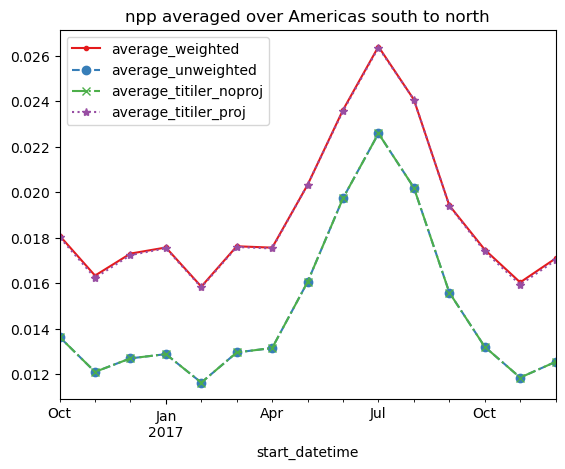

In [19]:
fig = plt.figure()
ax = fig.gca()

ax.set_prop_cycle(
    linestyle=['-', '--', '-.', ':'],
    color=["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"],
    marker=['.', 'o', 'x', '*']
)
df_all.plot(title=f"{ASSET_NAME} averaged over {AOI_NAME}", ax=ax) ;

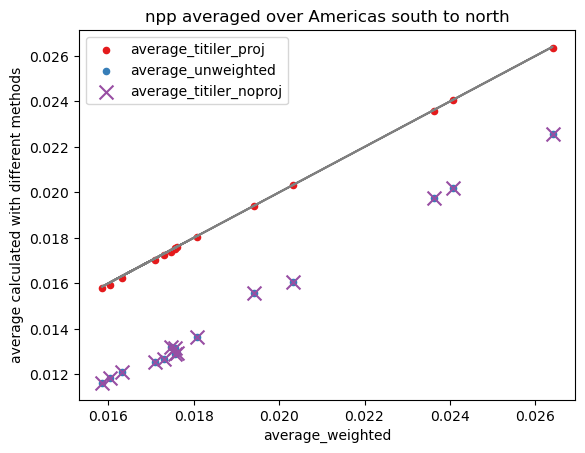

In [20]:
fig = plt.figure()
ax = fig.gca()

ax.plot(df_all["average_weighted"], df_all["average_weighted"], color="grey")

for key, style in {
    "average_titiler_proj": dict(c="#e41a1c"),
    "average_unweighted": dict(c="#377eb8"),
    "average_titiler_noproj": dict(c="#984ea3", marker="x", s=100)
}.items():
    df_all.plot.scatter("average_weighted", key, ax=ax, label=key, **style)

ax.set_title(f"{ASSET_NAME} averaged over {AOI_NAME}")
ax.set_ylabel("average calculated with different methods") ;

In [21]:
def rmse(a, b):
    return np.sqrt(
        np.mean(
            (a - b) ** 2
        )
    )

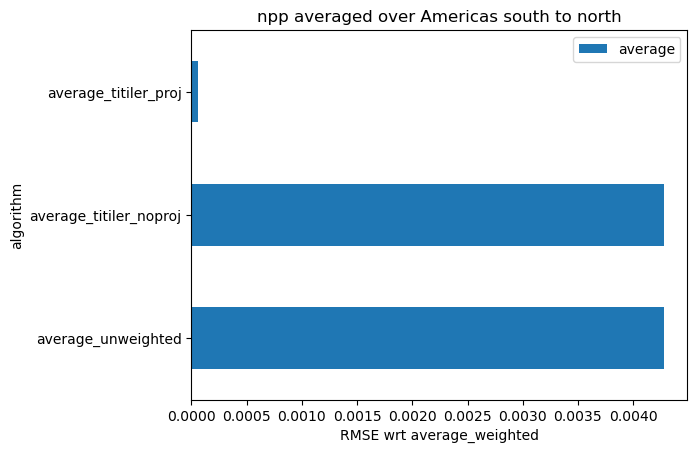

In [22]:
keys = ["average_unweighted", "average_titiler_noproj", "average_titiler_proj"]

df_rmse = pd.DataFrame(
    {
        "algorithm": keys,
        "average": [rmse(df_all[key], df_all["average_weighted"]) for key in keys]
    }    
)

df_rmse = df_rmse.set_index("algorithm")
df_rmse.plot.barh(xlabel="RMSE wrt average_weighted", title=f"{ASSET_NAME} averaged over {AOI_NAME}") ;